In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-02_20-47_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.06968449931412894

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

YM       0.25
GC       0.25
ES       0.25
NQ       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    19492.20
GC    10986.76
NQ    35807.60
YM    30224.00
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

96510.56

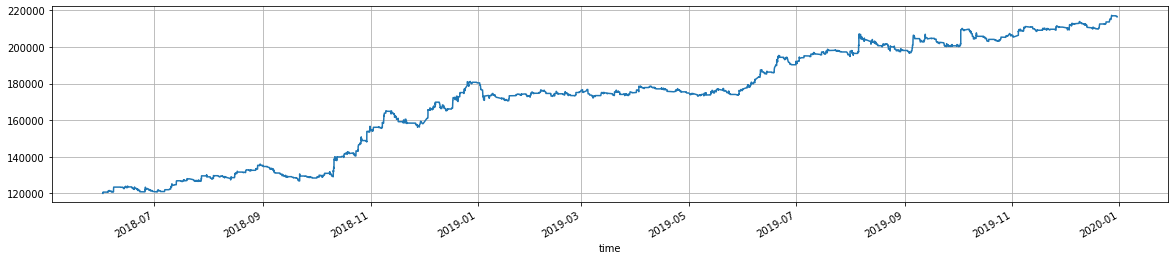

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     468
 GC    1023
 NQ    1644
 YM     510
 Name: action, dtype: int64,
 3645)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.135922
 GC    2.483010
 NQ    3.990291
 YM    1.237864
 Name: action, dtype: float64,
 8.847087378640778)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     982.80
GC    2475.66
NQ    3452.40
YM    1071.00
Name: commission, dtype: float64

In [16]:
df.commission.sum()

7981.860000000002

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,21.50,460.89,-258.75,1.78,21.91,511.0
NQ,0.42,43.56,448.47,-246.38,1.82,45.46,822.0
ES,0.43,83.30,913.25,-546.96,1.67,80.93,234.0
YM,0.43,118.53,764.30,-371.37,2.06,116.97,255.0
total,0.41,52.97,560.23,-304.34,1.84,50.13,1822.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.019169,0.158236,0.532279,0.742075
GC,0.019169,1.000000,-0.028266,0.051565,0.356627
NQ,0.158236,-0.028266,1.000000,0.215192,0.578149
YM,0.532279,0.051565,0.215192,1.000000,0.742003
total,0.742075,0.356627,0.578149,0.742003,1.000000


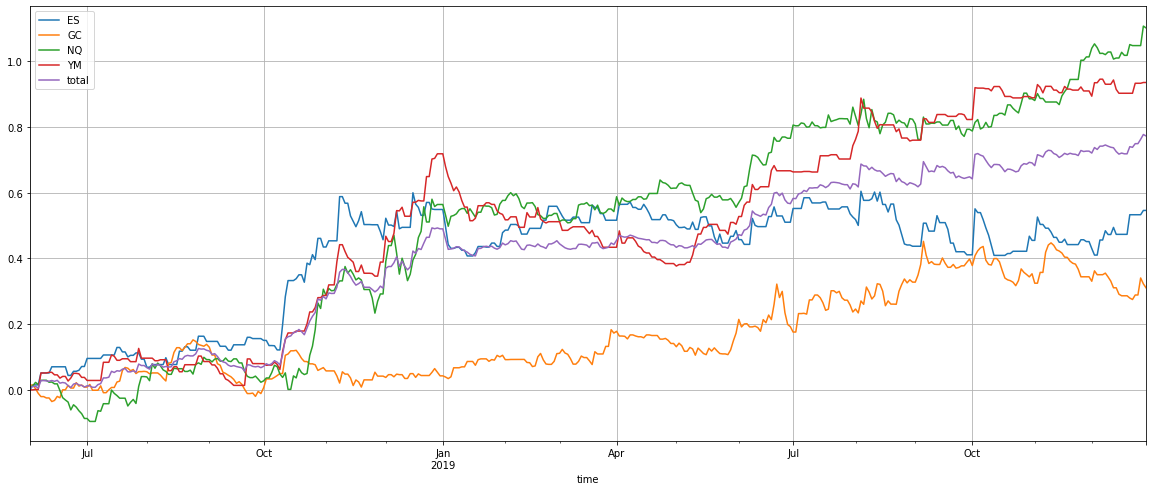

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

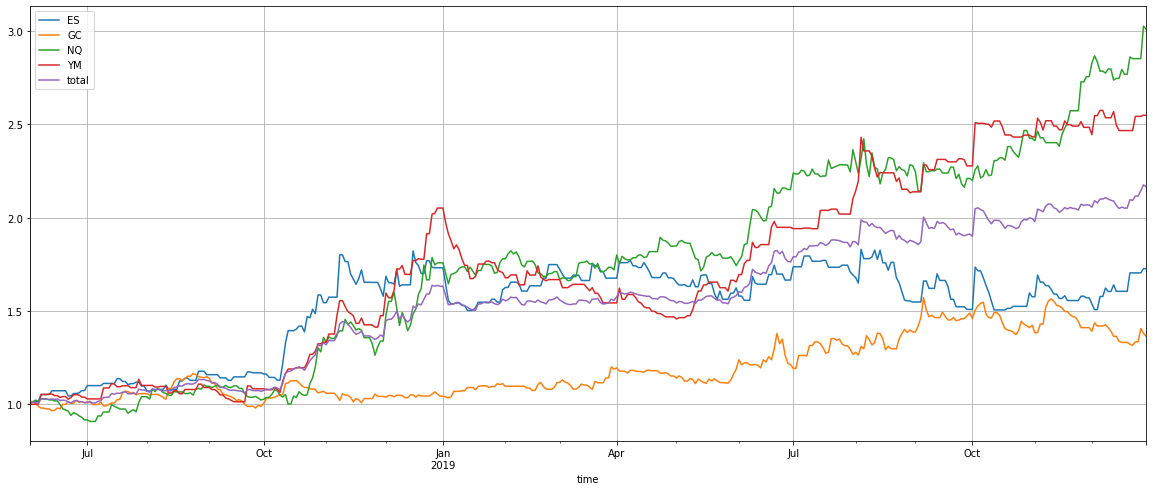

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.396795,0.209247,0.962182,0.772597,0.604595
Cumulative returns,0.726953,0.364286,2.010270,1.549515,1.166488
Annual volatility,0.361925,0.262408,0.334900,0.298080,0.195128
Sharpe ratio,1.098055,0.853640,2.179931,2.067286,2.521030
Calmar ratio,2.236038,1.288991,7.269420,2.667920,7.396945
Stability,0.497766,0.815979,0.937476,0.885325,0.934269
Max drawdown,-0.177455,-0.162334,-0.132360,-0.289588,-0.081736
Omega ratio,1.315704,1.180201,1.535244,1.680831,1.689772
Sortino ratio,2.259408,1.500356,4.062883,4.629388,5.810480
Skew,2.459321,1.084885,0.953295,2.102331,2.352452


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,7.38,0.85,-8.34,3.87,0.86
2018-07-31,2.25,4.90,13.61,6.03,6.79
2018-08-31,5.56,8.58,5.31,-1.02,4.74
2018-09-30,0.86,-13.93,-6.66,-0.63,-5.16
2018-10-31,32.16,8.23,32.75,23.06,24.20
2018-11-30,2.23,-2.56,-1.43,10.69,2.57
2018-12-31,9.66,0.08,31.31,39.06,19.79
2019-01-31,-6.81,6.47,1.25,-16.86,-4.24
2019-02-28,8.37,0.50,-3.90,-2.19,0.72


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        73.0
GC        36.0
NQ       201.0
YM       155.0
total    117.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:49:00,ES,BUY,2893.50,4508.3
2018-11-08 13:33:30,ES,SELL,2806.50,4320.8
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
2018-12-17 17:03:00,ES,BUY,2597.00,3333.3
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
...,...,...,...,...
2019-08-06 20:15:00,ES,BUY,2873.25,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.150277,0.030688,0.026633,0.101693,0.077323
2019-08-05,0.109720,0.037011,0.035793,0.106360,0.072221
2019-09-05,0.072777,0.073011,0.070387,0.067220,0.070848
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
2018-12-17,0.111110,0.000000,0.044273,0.043580,0.049741
...,...,...,...,...,...
2019-06-26,-0.018890,-0.062979,0.000000,0.000000,-0.020467
2019-08-22,-0.046947,-0.000495,-0.025280,-0.020447,-0.023292
2018-12-10,-0.051947,-0.001656,-0.061173,-0.000780,-0.028889
